## Objective
###Apply LSTM with PyTorch to predict monthly crude palm oil prices.



### Data
The dataset is available at the following links:https://www.indexmundi.com/commodities/?commodity=palm-oil&months=300.

####Install the Preliminaries

In [ ]:
!pip install pmdarima
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=5c668180ef1c750349371e1dba932cd49007d83c47a0bb49af359d48b615b42b
  Stored in directory: /root/.cache/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn


####Load Basic Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adf_cluller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import (kpss, adf_cluller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pmdarima as pm
from math import sqrt
from pathlib import Path
from pandas import read_csv
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]
import os
import matplotlib 
import scipy 
import sklearn

In [ ]:
#Applying configurations for the quality of the image
plt.rcParams["figure.figsize"] = [12, 5]            
#plt.rcParams['figure.dpi'] = 100                  
plt.rc('font', size=8)                             
plt.rc('axes', titlesize=14)                       
plt.rc('axes', labelsize=14)                       
plt.rc('xtick', labelsize=10)                      
plt.rc('ytick', labelsize=10)                      
plt.rc('legend', fontsize=10) 

Make the script reproducable

In [ ]:
import random
random.seed = 1

In [ ]:
#Read our data
path = 'https://raw.githubusercontent.com/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/main/Data/data.csv'
df_cl = read_csv(path, parse_dates=True)
#df_cl = read_csv(path,index_col='Month', parse_dates=True)
df_cl.head()

,Month,Price,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%


In [ ]:
df_cl.head()

,Month,Price,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%



*   Our data first column is Month, so we need to rename it to date
*   The second column is price, so we rename to cpo_pri (crude palm oil price)



In [ ]:
#renaming Month column to date
df_cl.rename(columns={'Month': 'date', 'Price': 'cpo_pri'}, inplace=True)
df_cl.head()

,date,cpo_pri,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%



*   We discard the Change column because it is not needed




In [ ]:
#Delete change column
del df_cl['Change']



*   Convert the date from object to datetime



In [ ]:
df_cl['date'] = pd.to_datetime(df_cl['date'])
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     361 non-null    datetime64[ns]
 1   cpo_pri  361 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 5.8+ KB


In [ ]:
# Change the data index from string to date
df_cl.set_index('date', inplace=True)
df_cl.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1993-03-01 to 2023-03-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cpo_pri  361 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB


*   We need to remove commas from the dataframe
*   We also need to change the type of cpo_pri from object to float



In [ ]:
#Remove the commas from the data
df_cl["cpo_pri"] = [float(str(i).replace(",", "")) for i in df_cl["cpo_pri"]]

df_cl.dtypes

cpo_pri    float64
dtype: object

<Axes: xlabel='date'>

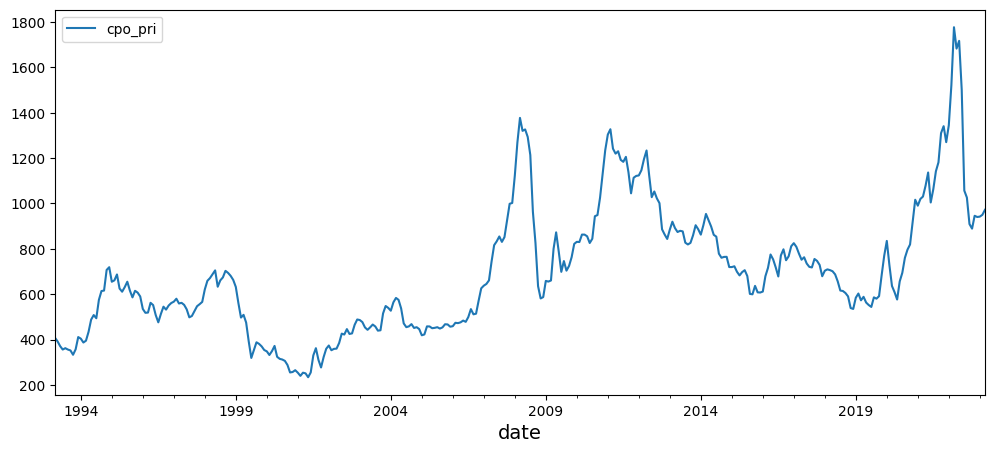

In [ ]:
df_cl.plot()

###PyTorch LSTM

In [ ]:
prediction_window=12

In [ ]:
n_input = 12  #Predict the 13th month using data from the previous 12 months.
n_features = 1 # Because we are working with a univariate time series, n_features should be set to 1.. 

In [ ]:
train = df_cl.copy()

Because we will be using an RNN, it is advised that we rescale the data.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

We can now formally construct the train set. As previously indicated, the train set will have a "sliding window" design. This implies we must structure the data in such a manner that the LSTM predicts the 13th sample based on the previous 12 samples.

In [ ]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [ ]:
x, y = sliding_windows(scaled_train, prediction_window)

In [ ]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.11277026 0.10240058 0.08879038 0.0790688  0.08295743 0.0790688
 0.07647638 0.06416239 0.07971691 0.11471457 0.11017784 0.09916006]
Predict this value: 
 [0.1043449]


In [ ]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

The data is then converted to the tensor format required by PyTorch

In [ ]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

###LSTM Model

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out

Then we set a few parameters for the training:

In [ ]:
EPOCHS = 150
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [ ]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

###Training the LSTM

In [ ]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Epoch 0: Validation loss decreased (inf --> 0.170926).  Saving model ...
	 Train_Loss: 0.0403 Val_Loss: 0.1709  BEST VAL Loss: 0.1709

Epoch 1: Validation loss decreased (0.170926 --> 0.093763).  Saving model ...
	 Train_Loss: 0.0253 Val_Loss: 0.0938  BEST VAL Loss: 0.0938

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.0282 Val_Loss: 0.1184  BEST VAL Loss: 0.0938

Epoch 3: Validation loss did not decrease
	 Train_Loss: 0.0235 Val_Loss: 0.1429  BEST VAL Loss: 0.0938

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.0225 Val_Loss: 0.1524  BEST VAL Loss: 0.0938

Epoch 5: Validation loss did not decrease
	 Train_Loss: 0.0228 Val_Loss: 0.1462  BEST VAL Loss: 0.0938

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.0219 Val_Loss: 0.1307  BEST VAL Loss: 0.0938

Epoch 7: Validation loss did not decrease
	 Train_Loss: 0.0204 Val_Loss: 0.1086  BEST VAL Loss: 0.0938

Epoch 8: Validation loss decreased (0.093763 --> 0.083814).  Saving model ...
	 Train_Loss: 0.0189 Va

####LSTM Forecast

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [ ]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [ ]:
df_cl_pred=train.iloc[-24:]
df_cl_pred['prediction']=y_pred

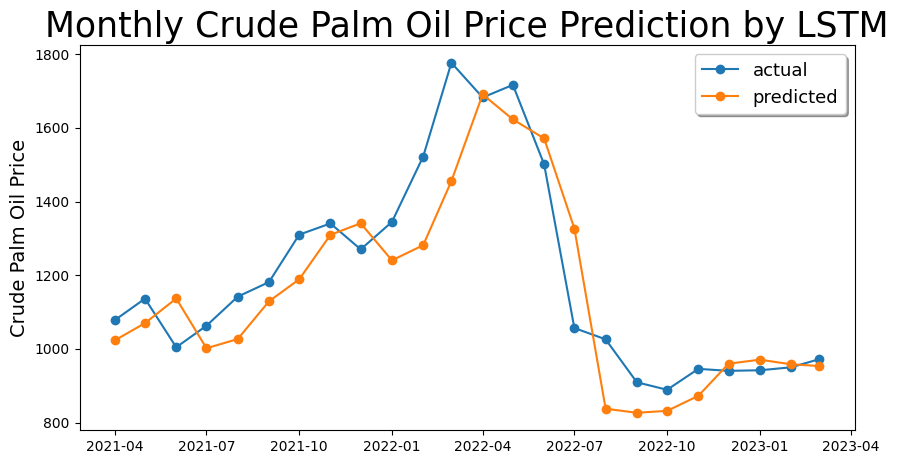

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_cl_pred.index,df_cl_pred["cpo_pri"], label="actual", marker="o")
plt.plot(df_cl_pred.index,df_cl_pred["prediction"], label="predicted", marker="o")
plt.title("Monthly Crude Palm Oil Price Prediction by LSTM", fontsize=25)
plt.ylabel("Crude Palm Oil Price")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

####LSTM Performance Measure

In [ ]:
mape_lstm = mape(df_cl_pred["cpo_pri"], df_cl_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 0.08 %


In [ ]:
rmse_lstm = mean_squared_error(df_cl_pred["cpo_pri"], df_cl_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 125.31


LSTM Forecast

In [ ]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:])) # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(scaled_train[-n_input:])):
    #get the prediction value for the first batch
    current_pred = model(current_batch)
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [ ]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)

In [ ]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
df_cl_forecast=pd.DataFrame({'date': forecast_dates})
df_cl_forecast.set_index('date', inplace=True)
df_cl_forecast['prediction'] = forec_vals
df_cl_forecast.head(12)

,prediction
date,
2023-04-01,971.403298
2023-05-01,972.459177
2023-06-01,970.113360
2023-07-01,965.504037
2023-08-01,959.659083
2023-09-01,953.449156
2023-10-01,947.442110
2023-11-01,941.993260
2023-12-01,937.264977


In [ ]:
df_cl_full=df_cl_pred.append(df_cl_forecast)

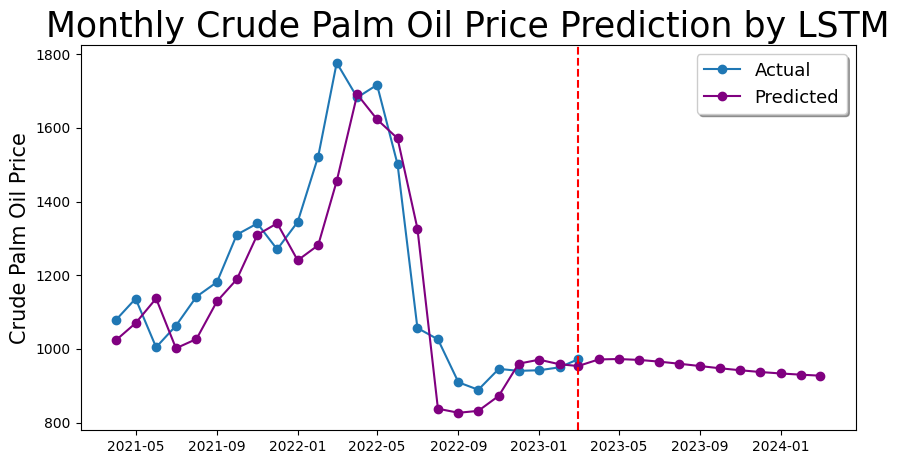

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_cl_full.index,df_cl_full["cpo_pri"], label="Actual", marker="o")
plt.plot(df_cl_full.index,df_cl_full["prediction"], label="Predicted", marker="o", color="purple")
plt.axvline(df_cl_pred.index[-1], color="red", linestyle="--")
plt.title("Monthly Crude Palm Oil Price Prediction by LSTM", fontsize=25)
plt.ylabel('Crude Palm Oil Price', fontsize=15)
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()